##Importing packages

In [1]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

**Importing dataset**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dress.csv to dress.csv


Head part of our dataset

In [4]:
df = pd.read_csv('dress.csv')
df.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


In [5]:
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

<Figure size 432x288 with 0 Axes>

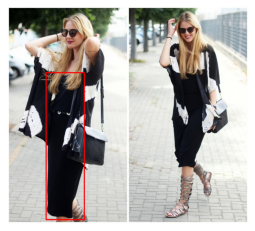

In [6]:
plt.figure()
show_image_from_url(df['image_url'].loc[9564])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _unit_id             15702 non-null  int64  
 1   category             15702 non-null  object 
 2   category:confidence  15702 non-null  float64
 3   image_url            15702 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 490.8+ KB


In [8]:
print('All categories : \n ', df['category'].unique())

All categories : 
  ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


In [9]:
n_classes = df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [10]:
#Remove the category 'OTHER' from the dataset

df = df.loc[(df['category'] != 'OTHER')].reset_index(drop=True)

In [11]:
def image_processing(image_url):

  """
  Converts the URL of any image to an array of size 100x1 
  The array represents an OpenCV grayscale version of the original image
  The image will get cropped along the biggest red contour (4 line polygon) tagged on the original image (if any)
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")                         

  #Read the numpy arrays as color images in OpenCV
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)

  #Convert to HSV for creating a mask
  image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

  #Convert to grayscale that will actually be used for training, instead of color image 
  image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

  #Create a mask that detects the red rectangular tags present in each image
  mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))

  #Get the coordinates of the red rectangle in the image, 
  #But take entire image if mask fails to detect the red rectangle
  if len(np.where(mask != 0)[0]) != 0:
    y1 = min(np.where(mask != 0)[0])
    y2 = max(np.where(mask != 0)[0])
  else:
    y1 = 0                                     
    y2 = len(mask)
  
  if len(np.where(mask != 0)[1]) != 0:
    x1 = min(np.where(mask != 0)[1])
    x2 = max(np.where(mask != 0)[1])
  else:
    x1 = 0
    x2 = len(mask[0])

  #Crop the grayscle image along those coordinates
  image_cropped = image_gray[y1:y2, x1:x2]

  #Resize the image to 100x100 pixels size
  image_100x100 = cv2.resize(image_cropped, (100, 100))

  #Save image as in form of array of 10000x1
  image_arr = image_100x100.flatten()
  return image_arr

In [12]:
"""
image_list = []

for url in df['image_url'] :
  image_list.append(image_processing(url))

X = np.array(image_list)

X = X/255

X = np.save('X.npy', X)
"""

"\nimage_list = []\n\nfor url in df['image_url'] :\n  image_list.append(image_processing(url))\n\nX = np.array(image_list)\n\nX = X/255\n\nX = np.save('X.npy', X)\n"

In [13]:
pip install gdown

In [14]:
import gdown

url = 'https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba'
output = 'X.npy'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba
To: /content/X.npy
1.22GB [00:04, 252MB/s]


'X.npy'

In [15]:
X = np.load('X.npy')
X[0:3]
X.shape

array([[0.29803922, 0.29803922, 0.29803922, ..., 0.60392157, 0.6       ,
        0.29803922],
       [0.4627451 , 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922],
       [0.30196078, 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922]])

(15189, 10000)

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff7584f828>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff7500b1d0>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff74fc0b38>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff74f83160>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff74f32c18>, (-0.5, 99.5, 99.5, -0.5))

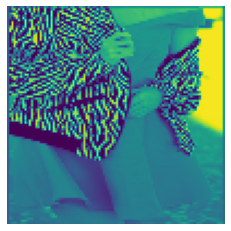

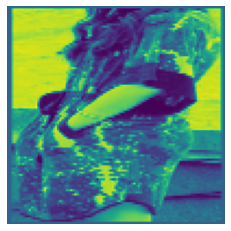

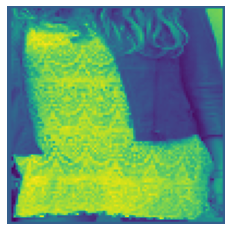

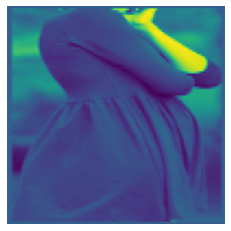

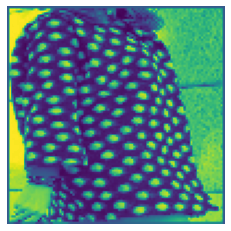

In [16]:
#Select 5 processed images at random from 'X' and plot 

np.random.seed(17)
for i in np.random.randint(0, len(X), 5):
  plt.figure()
  plt.imshow(X[i].reshape(100, 100)), plt.axis('off')

In [17]:

encoder = LabelEncoder()
Targets = encoder.fit_transform(df['category'])
Targets
Targets.shape

array([ 6,  8,  9, ..., 12, 15,  9])

(15189,)

In [18]:
#One-hot encoding of the Target vector

Y = to_categorical(Targets, num_classes = n_classes)
Y[0:3]
Y.shape

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

(15189, 17)

In [19]:
#Segregation of a test set for testing on the trained model

X_test = X[14000:,]
Y_test = Y[14000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:14000,], Y[:14000,], test_size=0.15, random_state=13)

In [20]:


img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(2100, 100, 100, 1)

In [21]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4

In [22]:


save_at = "model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

Epoch 1/15
119/119 [==============================] - 265s 2s/step - loss: 3.2785 - accuracy: 0.5265 - val_loss: 3.4402 - val_accuracy: 0.4452
Epoch 2/15
119/119 [==============================] - 265s 2s/step - loss: 1.3904 - accuracy: 0.6480 - val_loss: 1.9618 - val_accuracy: 0.5038
Epoch 3/15
119/119 [==============================] - 264s 2s/step - loss: 1.3369 - accuracy: 0.6560 - val_loss: 3.9760 - val_accuracy: 0.5714
Epoch 4/15
119/119 [==============================] - 264s 2s/step - loss: 1.2493 - accuracy: 0.6775 - val_loss: 1.5382 - val_accuracy: 0.6233
Epoch 5/15
119/119 [==============================] - 264s 2s/step - loss: 1.2185 - accuracy: 0.6851 - val_loss: 1.3264 - val_accuracy: 0.6610
Epoch 6/15
119/119 [==============================] - 264s 2s/step - loss: 1.1913 - accuracy: 0.6895 - val_loss: 1.3655 - val_accuracy: 0.6719
Epoch 7/15
119/119 [==============================] - 263s 2s/step - loss: 1.1565 - accuracy: 0.6994 - val_loss: 1.3524 - val_accuracy: 0.6600

<Figure size 432x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

(0.4, 0.9)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 <a list of 10 Text major ticklabel objects>)

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 6 Text major ticklabel objects>)

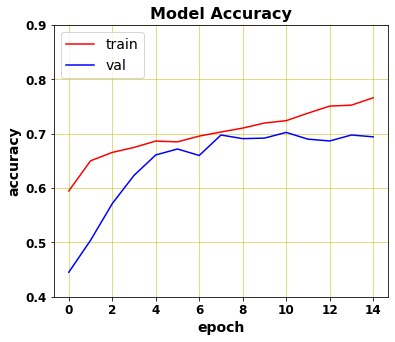

In [23]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [24]:
#Run model on the held-out test set

model = load_model('model.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  70.65 %


<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff6e487390>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'floral')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff6dc34e48>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'polka dot')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff6e6235f8>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'plain')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff6dc100f0>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7eff6dbbbc50>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'stripes')

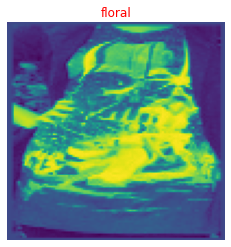

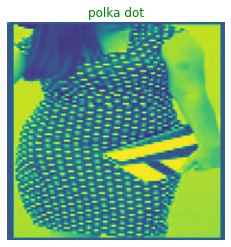

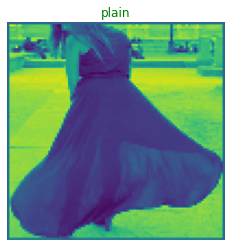

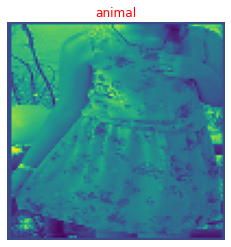

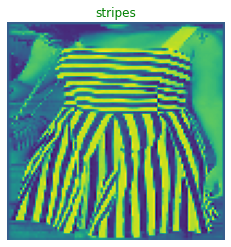

In [25]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

In [26]:
def find_similar_images(image_url, no_of_images):

  """
  Takes in an image_url, and number of similar images needed.
  Model makes prediction on the dress category in the image
  The original image and desired number of similar images from the dataset are plotted
  """

  X_query = image_processing(image_url)
  X_query = X_query/255
  X_query = X_query.reshape(1, 100, 100, 1)
  Y_query = np.round(model.predict(X_query))
  i = np.where(Y_query == 1)[0].sum()
  print('Type detected by model:', encoder.classes_[i].upper())
  df_req = df.loc[ df['category'] == encoder.classes_[i]]
  df_req = df_req.reset_index(drop=True)

  if no_of_images > len(df_req):
    return(print('number of images needed are more than similar images in the dataset'))

  plt.figure()
  show_image_from_url(image_url)
  plt.title('Query Image')

  c = 1
  np.random.seed(13)
  for j in np.random.randint(0, len(df_req), no_of_images):
    plt.figure()
    url = df_req['image_url'].iloc[j]
    show_image_from_url(url)
    plt.title('Similar Image {}'.format(c))
    c += 1

Type detected by model: ANIMAL


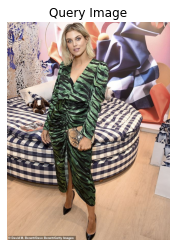

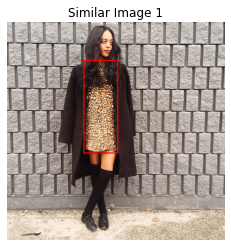

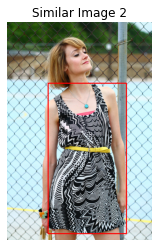

In [30]:
find_similar_images('https://i.dailymail.co.uk/1s/2018/11/06/23/5855600-6360713-Ashley_James_stuns_in_emerald_green_animal_print_dress_at_glitzy-a-123_1541546195058.jpg', 2)